### Problem Set 3

#### Name: Zunda Xu ( zunda@uchicago.edu)

### Part 1 QR decomposition

#### Problem 1

In [2]:
import numpy as np
from scipy import linalg as la
import cmath

In [3]:
def QR_decomposition(A):
    m,n = A.shape
    Q=np.copy(A)
    R=np.zeros((n,n))
    
    for i in range (n):
        R[i,i]=la.norm(Q[:,i])
        Q[:,i]=Q[:,i]/R[i,i]
        for j in range (i+1,n):
            R[i,j]=np.dot(np.transpose(Q[:,j]),Q[:,i])
            Q[:,j]=Q[:,j]-R[i,j]*Q[:,i]
    
    return Q,R

In [4]:
A=np.random.random((6,4))
Q,R= QR_decomposition(A)
print(A.shape,Q.shape,R.shape)

(6, 4) (6, 4) (4, 4)


In [5]:
Q1,R1=la.qr(A,mode="economic")
print(A.shape,Q1.shape,R1.shape)

(6, 4) (6, 4) (4, 4)


In [7]:
np.allclose(np.triu(R),R)

True

In [8]:
np.allclose(Q.T@Q, np.identity(4))

True

In [9]:
np.allclose(Q@R,A)

True

#### Problem 2

In [12]:
def getDet(A):
    m,n = A.shape
    if m!=n:
        print("A is not a square.")
        return
    
    Q1, R1 = QR_decomposition(A)
    det = 1
    for i in range(n):
        det *= R1[i,i]
    return det

In [13]:
B = np.random.random((5,5))
true_det = la.det(B)
my_det = getDet(B)
print("The difference is: ", true_det - my_det)

The difference is:  -0.00496537822398


#### Problem 3

In [14]:
def solveLinearSystem(A, b):
    if abs(la.det(A))<1e-6:
        print("A is not invertible")
        return
    Q1, R1 = QR_decomposition(A)
    y = np.dot(np.transpose(Q1), b)
    m, n = A.shape
    x = np.empty(n)
    for i in range(n-1, -1, -1):
        x[i] = y[i] / R1[i,i]
        for j in range(n):
            y[j] = y[j] - R1[j,i]*x[i]
        
    return x

In [15]:
A2 = np.random.random((5,5))
#add diagonals to make it invertible
A2 = A2 + 100*np.eye(5)
b2 = np.array([1,3,5,7,9])
print(np.dot(A2, solveLinearSystem(A2, b2)))

[ 1.  3.  5.  7.  9.]


#### Problem 4

In [16]:
def householder(A):
    #A should be a matrix of m*n and has rank n
    sign = lambda x : 1 if x>= 0 else -1
    
    m, n = A.shape
    R = np.copy(A)
    Q = np.eye(m)
    for k in range(n):
        u = np.copy(R[k:, k])
        u[0] = u[0] + sign(u[0])*la.norm(u)
        u = u / la.norm(u)
        R[k:, k:] = R[k:, k:] - 2 * np.outer(u, np.matmul(np.transpose(u), R[k:, k:]))
        Q[k:, :] = Q[k:, :] - 2 * np.outer(u, np.matmul(np.transpose(u), Q[k:, :]))
    return np.transpose(Q), R

In [17]:
A = np.random.random((5,3))
Q, R = la.qr(A)
print(A.shape, Q.shape, R.shape)

(5, 3) (5, 5) (5, 3)


In [18]:
my_Q, my_R = householder(A)
np.allclose(my_Q @ my_R, A)

True

In [19]:
np.allclose(my_Q, Q)

True

In [20]:
np.allclose(my_R, R)

True

#### Problem 5

In [22]:
def hessenberg(A):
    sign = lambda x : 1 if x>= 0 else -1
    
    #A is an invertible n*n matrix
    m, n = A.shape
    H = np.copy(A)
    Q = np.eye(m)
    for k in range(n-2):
        u = np.copy(H[k+1:, k])
        u[0] += sign(u[0]) * la.norm(u)
        u = u / la.norm(u)
        
        H[k+1: ,k:] -= 2 * np.outer(u, np.matmul(u, H[k+1:, k:]))
        H[:, k+1:] = H[:, k+1:] - 2 * np.outer(np.dot(H[:, k+1:], u), u.T)
        Q[k+1:, :] -= 2 * np.outer(u, np.matmul(np.transpose(u),Q[k+1:, :]))

    return H, np.transpose(Q)

A5 = np.random.random((8,8))
#add diagonals to make it invertible
A5 += 5*np.eye(8)
H, Q = la.hessenberg(A5, calc_q = True)
my_H, my_Q = hessenberg(A5)

In [23]:
np.allclose(my_H, H)

True

In [24]:
np.allclose(my_Q, Q)

True

### Part 2: Least Squares and Computing Eigenvalues

#### Problem 1 

In [25]:
def lsbyQR(A, b):
    #A is a m*n matrix, b is n*1 vector
    Q, R = la.qr(A, mode = "economic")
    #the linear system then becomes R \hat{x} = Q.T b
    #print(R)
    
    y = np.dot(np.transpose(Q), b)
    m, n = A.shape
    x_hat = np.empty(n)
    for i in range(n-1, -1, -1):
        x_hat[i] = y[i] / R[i,i]
        #update y
        for j in range(n):
            y[j] = y[j] - R[j,i]*x_hat[i]
        
    return x_hat

In [27]:
A = np.array([[-1,1], [0, 1], [1, -1], [-2, 1]])
b = np.array([0 , -1 , -2, 1])
lsbyQR(A, b)

array([-1. , -0.5])

#### Problem 2

In [28]:
import matplotlib.pyplot as plt

In [30]:
def LSLine():
    data = np.load("housing.npy")
    years = data[:, 0]
    prices = data[:, 1]
    
    constants = np.ones(len(years))
    A = np.column_stack((years, constants))
    coeff = lsbyQR(A, prices)
    print("Slope: ", coeff[0], "Intercept: ", coeff[1])
    plt.plot(years, prices, "o", markersize = 4)
    plt.xlabel("Year")
    plt.ylabel("Price Index")
    plt.title("Linear Regression of Price Index with Year")
    plt.plot(np.arange(18), coeff[0]*np.arange(18)+coeff[1])
    plt.show()

Slope:  3.37476604278 Intercept:  164.080962567


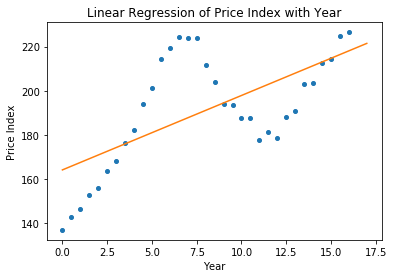

In [31]:
LSLine()

#### Problem 3

Is the calculated result the same from np.polyfit?  True


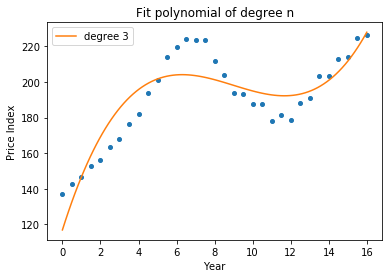

In [37]:
def fit_polynomial(n, x_vec, b_vec):
    # a degree n polynomial should have the form [a_n, a_{n-1}, ..., a_1, a_0].T * [x^n, ,,,, x, 1]
    # create a vandermonde matrix 
    A = np.vander(x_vec, n+1)
    coeff = la.lstsq(A, b_vec)[0]
    
    #regression polynomial
    my_poly = np.poly1d(coeff)
    
    #plot true values
    plt.plot(x_vec, b_vec, "o", markersize = 4)
    plt.xlabel("Year")
    plt.ylabel("Price Index")
    plt.title("Fit polynomial of degree n")
    
    #plot estimated values
    x_start = x_vec.min()
    x_end = x_vec.max()
    my_label = "degree " +str(n)
    plt.plot(np.linspace(x_start, x_end, 100), my_poly(np.linspace(x_start, x_end, 100)), label = my_label)
    plt.legend()
    
    #check with polyfit
    pf_coeff = np.polyfit(x_vec, b_vec, n)
    print("Is the calculated result the same from np.polyfit? ", np.allclose(coeff, pf_coeff))
    
    plt.show()
    

data = np.load("housing.npy")
years = data[:, 0]
prices = data[:, 1]
#degree 3
fit_polynomial(3, years, prices)

Is the calculated result the same from np.polyfit?  True


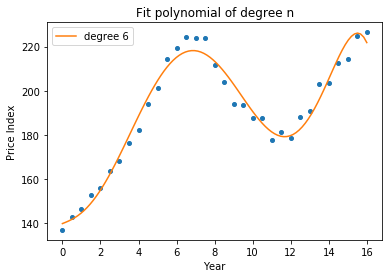

In [38]:
#degree 6
fit_polynomial(6, years, prices)

Is the calculated result the same from np.polyfit?  True


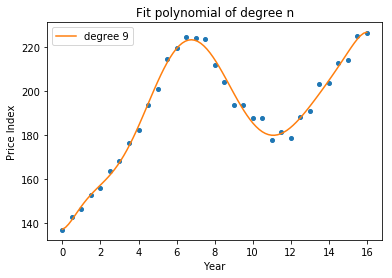

In [39]:
#degree 9
fit_polynomial(9, years, prices)

Is the calculated result the same from np.polyfit?  False


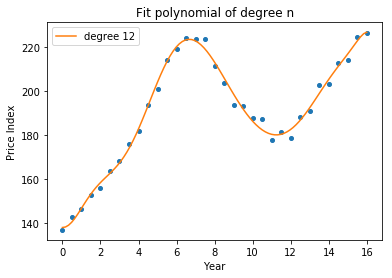

In [40]:
#degree 12
fit_polynomial(12, years, prices)

#### Problem 4

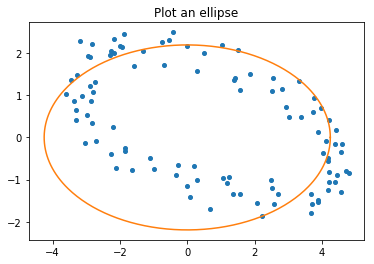

In [42]:
ellipse = np.load("ellipse.npy")
x_vec = ellipse[:, 0]
y_vec = ellipse[:, 1]

def plot_ellipse(x_vec, y_vec):
   #create a linear systems
    x2_vec = x_vec **2
    y2_vec = y_vec **2
    #RHS is a columns of ones
    b_vec = np.ones_like(x_vec)
    A = np.column_stack((x2_vec, y2_vec))
    coeff = la.lstsq(A, b_vec)[0]
    a = np.sqrt(1.0 / coeff[0])
    b = np.sqrt(1.0 / coeff[1])
    
    #plot
    plt.plot(x_vec, y_vec, "o", markersize = 4)
    theta_grid = np.linspace(0, 2*np.pi, 360)
    plt.plot(a*np.cos(theta_grid), b*(np.sin(theta_grid)))
    plt.title("Plot an ellipse")
    plt.show()
plot_ellipse(x_vec, y_vec)

#### Problem 5

In [43]:
def powerMethod(A, maxitr, tol):
    m, n = A.shape
    x_0 = np.random.rand(n) + np.ones(n) # make it larger to avoid rounding error
    x_0 = x_0 / la.norm(x_0)
    currentitr = 0
    diff = 10
    
    while (currentitr<maxitr) or (diff > tol):
        x_prime = np.matmul(A, x_0)
        x_prime = x_prime / la.norm(x_prime)
        diff = la.norm(x_prime - x_0)
        x_0 = x_prime
        currentitr += 1
    eigval = np.dot(x_0, np.matmul(A, x_0))
    eigvec = x_0
    return eigval, eigvec

A = (np.random.random((10,10)) ) # make it larger to avoid rounding error
eigs, vec = la.eig(A)
loc = np.argmax(eigs)
lamb , x = eigs[loc], vec[loc]
my_lamb, my_x = powerMethod(A, 10000, 1e-16)
print("Does the eigvalue converge to true eigvalue?")
print(np.allclose(lamb, my_lamb))
print("Does the corresponding eigenvector satisfy Ax = lambda x?")
print(np.allclose(np.abs(my_lamb * my_x), np.abs(np.dot(A, my_x))))


Does the eigvalue converge to true eigvalue?
True
Does the corresponding eigenvector satisfy Ax = lambda x?
True


#### Problem 6 

In [44]:
def QRfindeig(A, N, tol):
    m, n = A.shape    
    S, temp = la.hessenberg(A, calc_q = True)   
    for k in range(N):
        Q, R = la.qr(S)
        S = np.matmul(R, Q)
    eigs = []
    
    i = 0
    while i < n:
        if (i == (n-1)) or (abs(S[i+1,i])<tol):
            eigs.append(S[i,i])
        else:
            a = S[i,i]
            b = S[i,i+1]
            c = S[i+1, i]
            d = S[i+1, i+1]
            lamba_1 = 0.5 * (a + d + cmath.sqrt((a+d)^2 - 4*(a*d-b*c)))
            lamba_2 = 0.5 * (a + d - cmath.sqrt((a+d)^2 - 4*(a*d-b*c)))
            eigs.append(lambda_1)
            eigs.append(lambda_2)
            i += 1
        i += 1
    return eigs
            
#Construct a random symmetric matrix
A = np.random.random((5,5))
A = A + A.T
my_evals = QRfindeig(A, 1000, 1e-8)
my_evals.sort()
print("Calculation: ", my_evals)
evals, evecs = la.eig(A)
evals.sort()
print("True values: ", evals)

Calculation:  [-0.87834467436491814, -0.11548222622004391, 0.8448893706989864, 0.97890960208205857, 5.0490382957509796]
True values:  [-0.87834467+0.j -0.11548223+0.j  0.84488937+0.j  0.97890960+0.j
  5.04903830+0.j]


From the results shown above, we can find that the two results are almost the same.

### Part 3: SVD and Image Compression

#### Problem 1

In [47]:
def computeSVD(A,tol):
    lamda,V = la.eig(np.dot(A.conj().T,A))
    #get singular values
    sigma = np.sqrt(lamda)
    index = ((-1)*sigma).argsort()
    sigma = sigma[index]
    V = V[:,index]
    
    r = sum(i > tol for i in sigma)
    sigma1 = sigma[:r]
    V1 = V[:,:r]
    U1 = np.dot(A,V1)/sigma1
    return U1, sigma1, V1.conj().T

In [51]:
A = np.random.random((6,4))
U, s_vec, V = computeSVD(A, 1e-8)
print("Results:")
print("U is:")
print(U)
print("Sigma is:")
print(s_vec)
print("V^H is:")
print(V)

Results:
U is:
[[ 0.42178755+0.j -0.66375799+0.j  0.14349853+0.j  0.28942512+0.j]
 [ 0.36535515+0.j  0.57505026+0.j -0.18215559+0.j  0.13683074+0.j]
 [ 0.26752933+0.j  0.01221534+0.j  0.66160116+0.j -0.67177202+0.j]
 [ 0.26926052+0.j -0.24301106+0.j -0.71155129+0.j -0.60164736+0.j]
 [ 0.54549843+0.j -0.11748058+0.j -0.00476815+0.j  0.28928350+0.j]
 [ 0.49695993+0.j  0.39463559+0.j  0.04672724+0.j  0.02383930+0.j]]
Sigma is:
[ 2.16963261+0.j  0.94486510+0.j  0.39194819+0.j  0.34681929+0.j]
V^H is:
[[ 0.56179438  0.26357075  0.69308111  0.36681891]
 [ 0.77465396  0.13891455 -0.46797478 -0.40201193]
 [ 0.06899331  0.14859559 -0.54694474  0.82098156]
 [ 0.28202523 -0.94294886  0.03859575  0.17268346]]


In [52]:
U2, s_vec2, V2 = la.svd(A)
print("True SVD:")
print(U2)
print(s_vec2)
print(V2)

True SVD:
[[-0.42178755 -0.66375799 -0.14349853 -0.28942512 -0.51141599 -0.1249622 ]
 [-0.36535515  0.57505026  0.18215559 -0.13683074 -0.2611509  -0.64477105]
 [-0.26752933  0.01221534 -0.66160116  0.67177202  0.05666234 -0.18993282]
 [-0.26926052 -0.24301106  0.71155129  0.60164736 -0.00545735  0.01139401]
 [-0.54549843 -0.11748058  0.00476815 -0.2892835   0.77632351 -0.0473699 ]
 [-0.49695993  0.39463559 -0.04672724 -0.0238393  -0.25364403  0.72815283]]
[ 2.16963261  0.9448651   0.39194819  0.34681929]
[[-0.56179438 -0.26357075 -0.69308111 -0.36681891]
 [ 0.77465396  0.13891455 -0.46797478 -0.40201193]
 [-0.06899331 -0.14859559  0.54694474 -0.82098156]
 [-0.28202523  0.94294886 -0.03859575 -0.17268346]]


From the results shown above, we find that the results are the same.

#### Problem 2

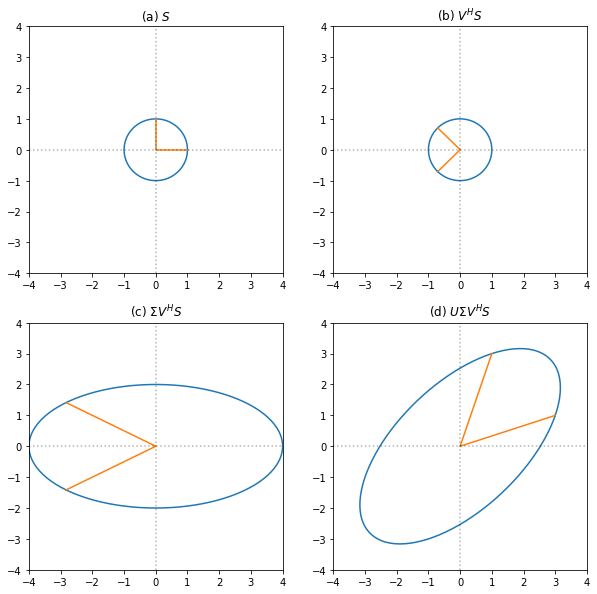

In [54]:
def visualizeSVD(A):
    # A is an 2*2 matrix
    S=np.zeros((2,200))
    theta=np.linspace(0.0, 2*np.pi, 200)
    theta=np.sort(theta)
    S[0]=np.cos(theta)
    S[1]=np.sin(theta)
    E=np.array(([1,0,0],[0,0,1]))
    
    
    
    
    plt.figure(figsize = [10,10])
    
    axis = np.linspace(-4, 4, 10)
    
    U,sigma,Vh = la.svd(A, full_matrices=True)
    Sigma=np.diag(sigma)
    VhS = np.dot(Vh, S)
    VhE = np.dot(Vh, E)
    SigmaVhS = np.dot(Sigma, VhS)
    SigmaVhE = np.dot(Sigma, VhE)
    USigmaVhS = np.dot(U, SigmaVhS)
    USigmaVhE = np.dot(U, SigmaVhE)
        
    #plot 1
    plt.subplot(2,2,1)
    plt.plot(S[0], S[1])
    plt.plot(E[0], E[1])
    plt.plot(axis, np.zeros_like(axis), "k:", alpha = 0.3)
    plt.plot(np.zeros_like(axis), axis, "k:", alpha = 0.3)
    plt.xlim(-4,4)
    plt.ylim(-4,4)
    plt.title("(a) " + r"$S$")
        
    #plot 2
    plt.subplot(2,2,2)
    plt.plot(VhS[0], VhS[1])
    plt.plot(VhE[0], VhE[1])
    plt.plot(axis, np.zeros_like(axis), "k:", alpha = 0.3)
    plt.plot(np.zeros_like(axis), axis, "k:", alpha = 0.3)
    plt.xlim(-4,4)
    plt.ylim(-4,4)
    plt.title("(b) " + r"$V^H S$")
    
    #plot 3
    plt.subplot(2,2,3)
    plt.plot(SigmaVhS[0], SigmaVhS[1])
    plt.plot(SigmaVhE[0], SigmaVhE[1])
    plt.plot(axis, np.zeros_like(axis), "k:", alpha = 0.3)
    plt.plot(np.zeros_like(axis), axis, "k:", alpha = 0.3)
    plt.xlim(-4,4)
    plt.ylim(-4,4)
    plt.title("(c) " + r"$\Sigma V^H S$")
    
    #plot 4
    plt.subplot(2,2,4)
    plt.plot(USigmaVhS[0], USigmaVhS[1])
    plt.plot(USigmaVhE[0], USigmaVhE[1])
    plt.plot(axis, np.zeros_like(axis), "k:", alpha = 0.3)
    plt.plot(np.zeros_like(axis), axis, "k:", alpha = 0.3)
    plt.xlim(-4,4)
    plt.ylim(-4,4)
    plt.title("(d) " + r"$U \Sigma V^H S$")
    
    plt.show()
       
A = np.array([[3,1], [1,3]])
visualizeSVD(A)